# mESC analysis using the object oriented core

We redesigned the core of Cyclum to a more friendly object oriented core. The core is still under active development, but the major functions are already functional.

We still use the mESC dataset. For simplicity we have converted the dataset into TPM.
The original count data is available at ArrayExpress: [E-MTAB-2805](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-2805/). Tools to transform data are also provided and explained in the following sections.

## Import necessary packages

In [1]:
import pydot
%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
import sklearn as skl

In [3]:
import cyclum.tuning
import cyclum.models
from cyclum import writer


Using TensorFlow backend.


## Read data
Here we have label, so we load both. However, the label is not used until evaluation.

In [4]:
input_file_mask = '/home/shaoheng/Documents/data/mESC/mesc-tpm'

def preprocess(input_file_mask):
    """
    Read in data and perform log transform (log2(x+1)), centering (mean = 1) and scaling (sd = 1).
    """
    tpm = writer.read_df_from_binary(input_file_mask).T
    sttpm = pd.DataFrame(data=skl.preprocessing.scale(np.log2(tpm.values + 1)), index=tpm.index, columns=tpm.columns)
    
    label = pd.read_csv(input_file_mask + '-label.txt', sep="\t", index_col=0).T
    return sttpm, label

sttpm, label = preprocess(input_file_mask)

In [5]:
sttpm.shape

(288, 38293)

There is no convention whether cells should be columns or rows. Here we require cells to be rows.

## Set up the model and fit the model

In [6]:
model = cyclum.tuning.CyclumAutoTune(sttpm, max_linear_dims=5,
                                     epochs=300, rate=2e-4, verbose=100,
                                     encoder_width=[30, 20])

Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch: 100/300, loss:  0.7173, time elapsed:  40.42s, time left:  80.83s
epoch: 200/300, loss:  0.7106, time elapsed:  73.08s, time left:  36.54s
epoch: 300/300, loss:  0.7078, time elapsed:  105.33s, time left:  0.00s
[0.7078442639774747]
[0.6834711496280971, 0.6739115521460043, 0.6668002844388756, 0.660752216928628, 0.6550218174352341, 0.6501535050108507, 0.6453767464209467]
    1 linear dimensions...
epoch: 100/300, loss:  0.6775, time elapsed:  32.87s, time left:  65.75s
epoch: 200/300, loss:  0.6738, time elapsed:  65.31s, time left:  32.66s
epoch: 300/300, loss:  0.6728, time elapsed:  97.90s, time left:  0.00s
[0.7078442639774747, 0.672757989830441]
[0.6834711496280971, 0.6739115521460043, 0.6668002844388756, 0.660752216928628, 0.655021817435234

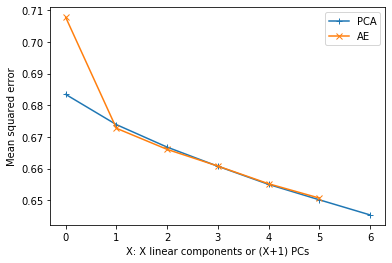

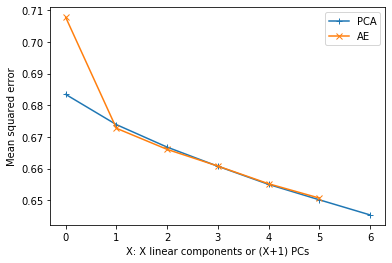

In [7]:
model.show_elbow()

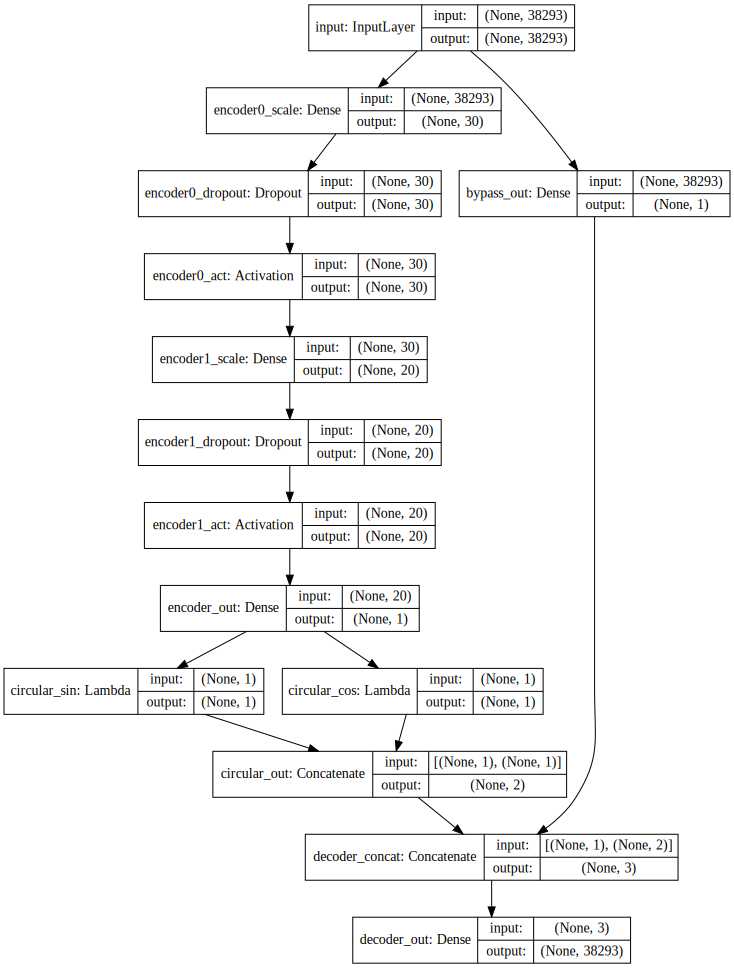

In [8]:
display(model.show_structure())


In [9]:
model.train(sttpm, epochs=800, verbose=100, rate=2e-4)

epoch: 100/800, loss:  0.6773, time elapsed:  33.98s, time left:  237.86s
epoch: 200/800, loss:  0.6737, time elapsed:  67.28s, time left:  201.84s
epoch: 300/800, loss:  0.6721, time elapsed:  100.73s, time left:  167.89s
epoch: 400/800, loss:  0.6717, time elapsed:  134.23s, time left:  134.23s
epoch: 500/800, loss:  0.6715, time elapsed:  167.82s, time left:  100.69s
epoch: 600/800, loss:  0.6713, time elapsed:  201.29s, time left:  67.10s
epoch: 700/800, loss:  0.6711, time elapsed:  234.75s, time left:  33.54s
epoch: 800/800, loss:  0.6709, time elapsed:  268.25s, time left:  0.00s


In [10]:
pseudotime = model.predict_pseudotime(sttpm)

## Illustrations
We illustrate the results on a circle, to show its circular nature. 
There is virtually no start and end of the circle.
Red, green and blue represents G0/G1, S and G2/M phase respectively.
The inner lines represents single cells. The cells spread across the
The areas outside

In [11]:
import cyclum.illustration

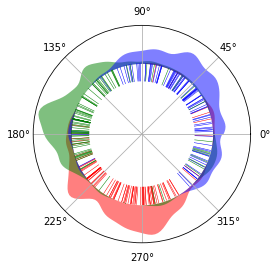

In [12]:
color_map = {'stage': {"g0/g1": "red", "s": "green", "g2/m": "blue"},
                 'subcluster': {"intact": "cyan", "perturbed": "violet"}}
cyclum.illustration.plot_round_distr_color(pseudotime, label['stage'], color_map['stage'])
pass

## Get the circular component and subtract it from the expression

In [13]:
circular_comp = model.get_circular_component(pseudotime)
noncircular_comp = sttpm - circular_comp

Text(0.5, 0, 'Pseudotime')

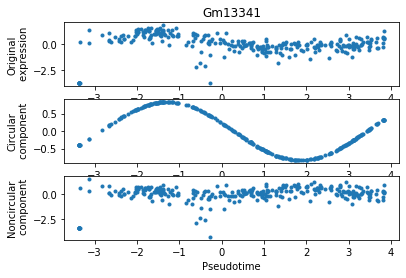

In [14]:
circular_load = np.sqrt((model.get_circular_loadings() ** 2).sum(axis=0))
max_ind = circular_load.argmax()

import matplotlib.pyplot as plt
plt.subplot(3, 1, 1)
plt.plot(pseudotime, sttpm.iloc[:, max_ind], '.')
plt.ylabel('Original\n expression')
plt.title(sttpm.columns[max_ind])
plt.subplot(3, 1, 2)
plt.ylabel('Circular\n component')
plt.plot(pseudotime, circular_comp[:, max_ind], '.')
plt.subplot(3, 1, 3)
plt.plot(pseudotime, noncircular_comp.iloc[:, max_ind], '.')
plt.ylabel('Noncircular\n component')
plt.xlabel('Pseudotime')
